In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import random
import os

# 스케일 처리
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import  MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# sklearn
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, Flatten, Dense, MaxPooling1D,Reshape
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.utils import to_categorical


In [2]:
class config:
    seed = 42
    device = "cuda:0"    
        
    lr = 1e-3
    epochs = 25
    batch_size = 32
    num_workers = 4
    train_5_folds = True
    
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

seed_everything(config.seed)

# 데이터 불러오기 및 전처리

In [3]:
# 데이터 불러오기
B7_TM_re2 = pd.read_csv('../data/B7/B7_TM_5x8.csv')
B7_MG = pd.read_csv('../data/B7/B7_MG.csv')
V3_TM_re2 = pd.read_csv('../data/V3/V3_TM_5x8.csv')
V3_MG = pd.read_csv('../data/V3/V3_MG.csv')

# B7과 V3데이터 합치기
TM = pd.concat([B7_TM_re2 ,V3_TM_re2 ], axis=1)
MG = pd.concat([B7_MG ,V3_MG ], axis=1)

MG[MG == 755.0] = 75.5

print(TM.shape, B7_TM_re2.shape, V3_TM_re2.shape, MG.shape, B7_MG.shape, V3_MG.shape)

(40, 494) (40, 266) (40, 228) (36, 494) (36, 266) (36, 228)


In [4]:
# 스케일 변환
def X_scale(X):
    scaler = RobustScaler()
    X_scaled= scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled)
    return X_scaled

# 이상치 정리
def outlier(X):
    q1 = X.quantile(0.25)
    q3 = X.quantile(0.75)
    IQR = q3-q1
    condition = (X > (q1 - 1.5*IQR )) & (X < (q3 + 1.5*IQR ))
    X_drop = X[condition]
    X_fill = X_drop.fillna(X_drop.interpolate()) # Nan값을 앞뒤의 값의 동일 간격으로 채우기
    X_fill = X_fill.fillna(method='ffill')
    X_fill = X_fill.fillna(method='bfill')
    return X_fill

# 1D-array 형식으로 변환
def X_array(X):
    N = X.shape[1]
    X_re = np.zeros((N, 40, 1))
    for k in range(N):
        X_re[k, :, 0]  = X.T.iloc[k,:]
    return X_re

# 2D-array 형식으로 변환
def X_array_2D(X):
    N = X.shape[1]
    X_re = np.zeros((N, 5, 8))
    for k in range(N):
        for i in range(5):
            X_re[k, i,: ]  = X.T.iloc[k,i*5:i*5+8]
    return X_re

# 1D-array 형식으로 변환
def Y_array(Y):
    N = Y.shape[1]
    Y_re = np.zeros((N,36))
    for k in range(N):
        Y_re[k, :] = Y.T.iloc[k,:]
    return Y_re

# y 스케일 변환
def Y_scale(Y): 
    scaler = StandardScaler()
    Y_scaled = scaler.fit_transform(Y)
    # Y_scaled = pd.DataFrame(Y_scaled)
    return scaler, Y_scaled


In [5]:
# 정의한 함수로 데이터 전처리 진행
X_scaled = X_scale(TM)
X_outliner = outlier(X_scaled)
X = X_array(X_outliner)
X_2D = X_array_2D(X_outliner)

Y_array = Y_array(MG)
scaler, Y = Y_scale(Y_array)

In [6]:
X.shape

(494, 40, 1)

In [7]:
MG

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,71.0,71.0,80.0,80.0,71.0,71.0,71.0,71.0,71.0,71.0,...,66.0,66.0,65.5,65.5,65.0,65.0,65.0,65.0,65.0,65.0
1,84.0,84.0,80.0,80.0,84.0,84.0,84.0,84.0,84.0,84.0,...,84.0,84.0,84.0,84.0,84.5,84.5,84.5,84.5,84.5,84.5
2,83.5,83.5,80.0,80.0,81.5,81.5,83.5,83.5,81.5,81.5,...,71.5,71.5,71.5,71.5,71.5,71.5,71.5,71.5,71.5,71.5
3,88.5,88.5,80.0,80.0,86.5,86.5,88.5,88.5,86.5,86.5,...,81.0,81.0,81.0,81.0,81.0,81.0,81.0,81.0,81.0,81.0
4,85.5,85.5,80.0,80.0,83.5,83.5,85.5,85.5,83.5,83.5,...,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0
5,86.0,86.0,80.0,80.0,84.0,84.0,86.0,86.0,84.0,84.0,...,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0,82.0
6,82.0,82.0,80.0,80.0,80.0,80.0,82.0,82.0,80.0,80.0,...,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0,73.0
7,85.0,85.0,80.0,80.0,85.0,85.0,85.0,85.0,85.0,85.0,...,81.0,81.0,81.0,81.0,81.0,81.0,81.0,81.0,81.0,81.0
8,72.0,72.0,80.0,80.0,72.0,72.0,72.0,72.0,72.0,72.0,...,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0
9,69.5,69.5,80.0,80.0,69.5,69.5,71.5,71.5,70.5,70.5,...,69.0,69.0,68.0,68.0,67.0,67.0,67.0,67.0,67.0,67.0


In [8]:
print('X의 shape: ', X.shape ,', Y의 shape:',Y.shape)

X의 shape:  (494, 40, 1) , Y의 shape: (494, 36)


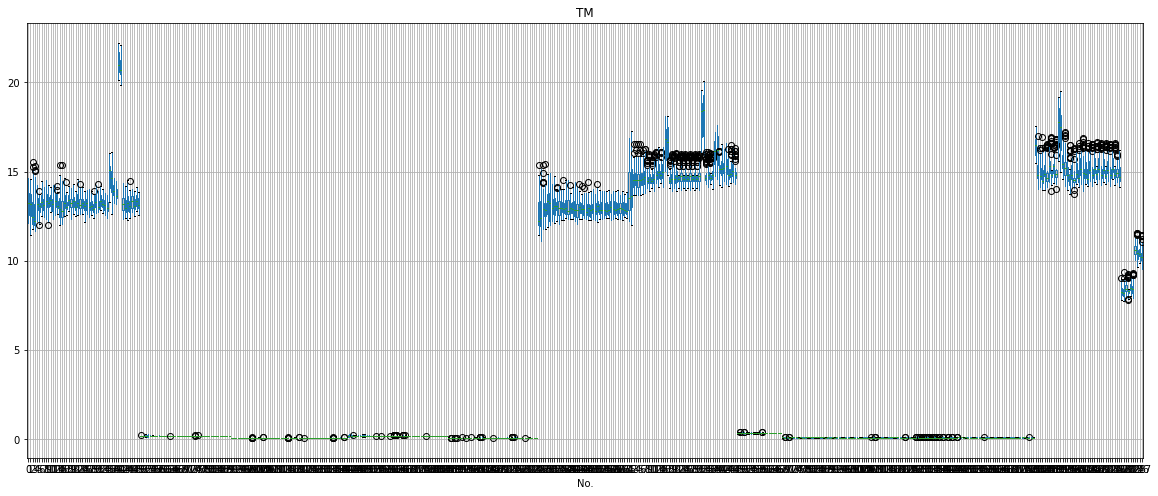

In [9]:
plt.figure(figsize=(20,8))
plt.title('TM')
plt.xlabel('No.')
TM.boxplot()
plt.show()

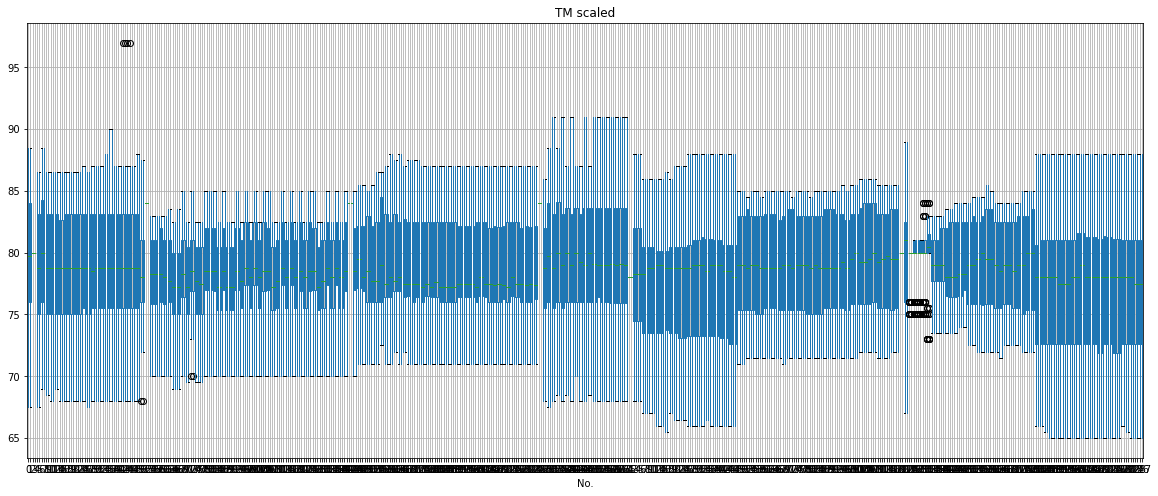

In [10]:
plt.figure(figsize=(20,8))
plt.title('TM scaled')
plt.xlabel('No.')
MG.boxplot()
plt.show()

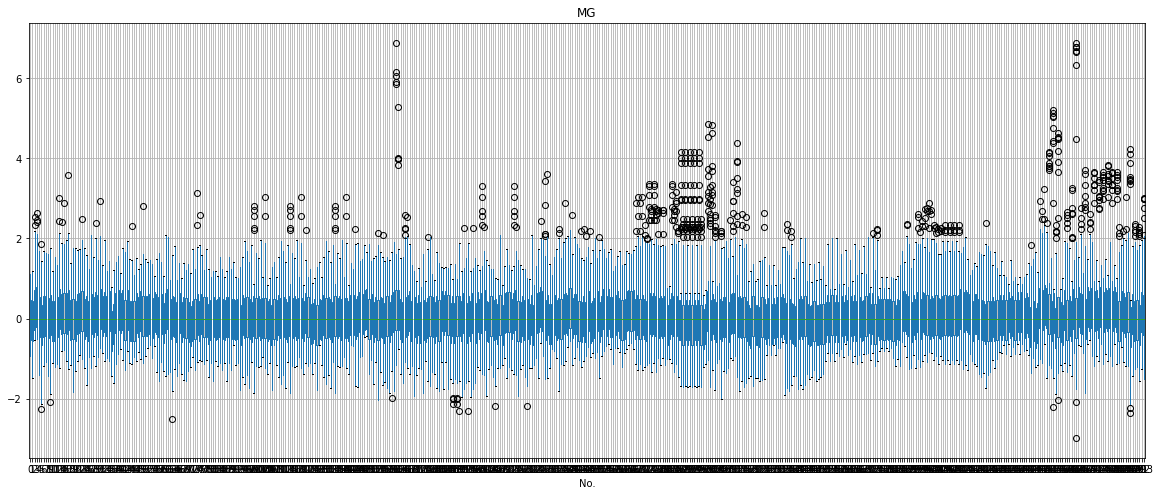

In [11]:
plt.figure(figsize=(20,8))
plt.title('MG')
plt.xlabel('No.')
X_scaled.boxplot()
plt.show()

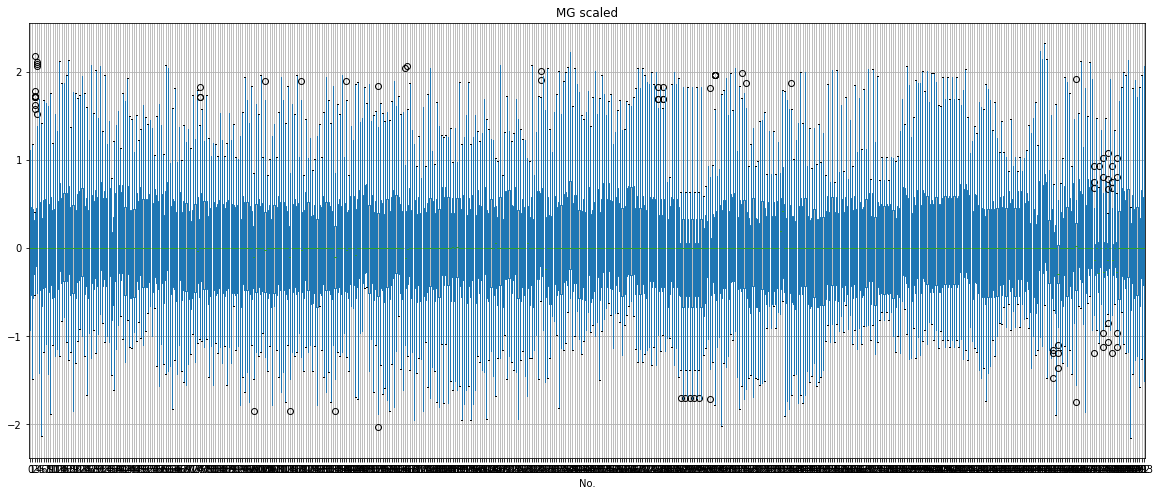

In [12]:
plt.figure(figsize=(20,8))
plt.title('MG scaled')
plt.xlabel('No.')
X_outliner.boxplot()
plt.show()

## 데이터 수 줄이기

In [13]:
# X, X_not,X_2D, X_2D_not, Y,Y_not = train_test_split(X,X_2D, Y, test_size=0.5, random_state=42)

In [14]:
X.shape

(494, 40, 1)

In [15]:
X_2D.shape

(494, 5, 8)

# 모델평가 함수 정의

In [16]:
def test_pred_plot(list,y_test, y_pred): 

    x_ax = range(36)

    plt.subplots(constrained_layout=True)
    for i,k in zip(range(1,5),list):
        plt.subplot(2,2,i)
        plt.plot(x_ax, y_test[k], label="test", color='y')
        plt.plot(x_ax, y_pred[k], label="pred", color='c')
        plt.legend()
        plt.title(k)
        plt.ylabel('MG Height')
        plt.xlabel('location')
    plt.show()

In [17]:
def test_pred_mean_plot(y_test, y_pred): 
    x_ax = range(36)
    plt.plot(x_ax, pd.DataFrame(y_test).mean(), label="test_mean", color='r')
    plt.plot(x_ax, pd.DataFrame(y_pred).mean(), label="pred_mean", color='b')
    #plt.ylim(-0.2,0.2)
    plt.legend()
    plt.ylabel('MG Height')
    plt.xlabel('location')
    plt.show()

In [18]:
def scaler_inv(y_test, y_pred):
    y_test_rev = scaler.inverse_transform(y_test)
    df_y_test = pd.DataFrame(y_test_rev.T)
    y_pred_rev = scaler.inverse_transform(y_pred)
    df_y_pred = pd.DataFrame(y_pred_rev.T)
    return y_test_rev, y_pred_rev, df_y_test, df_y_pred

# MLP

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_test.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_test.shape)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_val.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_val.shape)

X_train의 shape:  (395, 40, 1) , X_test의 shape: (99, 40, 1) , y_train의 shape:  (395, 36) , y_test의 shape: (99, 36)
X_train의 shape:  (316, 40, 1) , X_test의 shape: (79, 40, 1) , y_train의 shape:  (316, 36) , y_test의 shape: (79, 36)


In [20]:
def model_MLP(X_train, y_train, X_val, y_val):

    model = Sequential()
    model.add(Flatten(input_shape=(40,1)))
    model.add(Dense(416, activation='relu')) 
    model.add(Dense(416, activation='relu'))
    model.add(Dense(480, activation='relu'))
    model.add(Dense(36 , activation=keras.layers.LeakyReLU(alpha=0.3)))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train,     batch_size=12, 
                        epochs=200, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [21]:
model, history = model_MLP(X_train, y_train, X_val, y_val)

Epoch 1/200
27/27 [==============================] - 1s 9ms/step - loss: 0.6374 - mae: 0.6493 - val_loss: 0.4128 - val_mae: 0.4582
Epoch 2/200
27/27 [==============================] - 0s 4ms/step - loss: 0.2678 - mae: 0.3769 - val_loss: 0.3013 - val_mae: 0.3827
Epoch 3/200
27/27 [==============================] - 0s 4ms/step - loss: 0.1924 - mae: 0.3144 - val_loss: 0.2368 - val_mae: 0.3524
Epoch 4/200
27/27 [==============================] - 0s 4ms/step - loss: 0.1575 - mae: 0.2853 - val_loss: 0.1956 - val_mae: 0.3077
Epoch 5/200
27/27 [==============================] - 0s 4ms/step - loss: 0.1294 - mae: 0.2547 - val_loss: 0.1720 - val_mae: 0.2809
Epoch 6/200
27/27 [==============================] - 0s 4ms/step - loss: 0.1238 - mae: 0.2415 - val_loss: 0.1652 - val_mae: 0.2807
Epoch 7/200
27/27 [==============================] - 0s 4ms/step - loss: 0.0961 - mae: 0.2167 - val_loss: 0.1575 - val_mae: 0.2706
Epoch 8/200
27/27 [==============================] - 0s 4ms/step - loss: 0.0993 - m

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 416)               17056     
                                                                 
 dense_1 (Dense)             (None, 416)               173472    
                                                                 
 dense_2 (Dense)             (None, 480)               200160    
                                                                 
 dense_3 (Dense)             (None, 36)                17316     
                                                                 
Total params: 408,004
Trainable params: 408,004
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Loss')

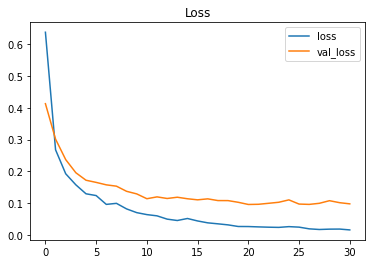

In [23]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')

In [24]:
y_pred = model.predict(X_test)

print('mae:',mean_absolute_error(y_test, y_pred), 'mse:',mean_squared_error(y_test, y_pred),'rmse:',np.sqrt(mean_squared_error(y_test, y_pred)), 'r2:',r2_score(y_test, y_pred))

4/4 [==============================] - 0s 2ms/step
mae: 0.17739390508416883 mse: 0.07287143850831679 rmse: 0.26994710316711457 r2: 0.9228397739575573


In [25]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred)) / y_test) * 100 
    
MAPE(y_test, y_pred)

5.097142172422454

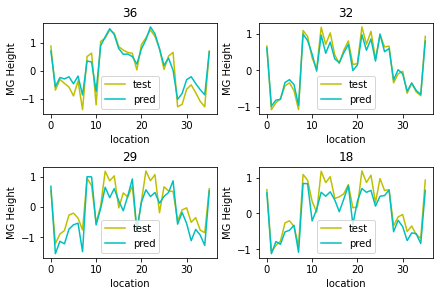

In [26]:
res = random.sample(range(1, y_test.shape[0]), 4)

test_pred_plot(res,y_test, y_pred)


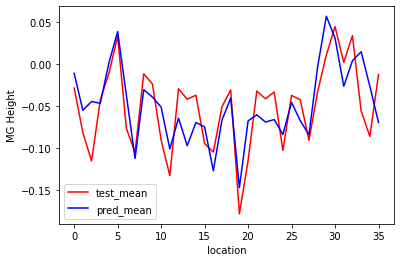

In [27]:
test_pred_mean_plot(y_test, y_pred)

In [28]:
y_test_rev, y_pred_rev, df_y_test, df_y_pred = scaler_inv(y_test, y_pred)

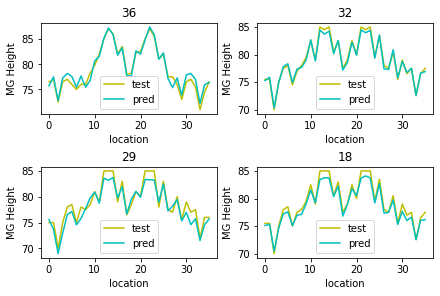

In [29]:
test_pred_plot(res, df_y_test, df_y_pred)

In [30]:
print('mae:',mean_absolute_error(y_test_rev, y_pred_rev), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev)), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae: 0.5703332457879579 rmse: 0.8606504920464262 r2: 0.9228397782653018


In [31]:
print('mae(%):',mean_absolute_error(y_test_rev, y_pred_rev)/y_test_rev.mean(), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev))/y_test_rev.mean(), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae(%): 0.007277721761504769 rmse: 0.010982307030624644 r2: 0.9228397782653018


# SVM

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_test.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_test.shape)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_val.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_val.shape)

X_train의 shape:  (395, 40, 1) , X_test의 shape: (99, 40, 1) , y_train의 shape:  (395, 36) , y_test의 shape: (99, 36)
X_train의 shape:  (316, 40, 1) , X_test의 shape: (79, 40, 1) , y_train의 shape:  (316, 36) , y_test의 shape: (79, 36)


In [33]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import RandomFourierFeatures

def model_SVM(X_train, y_train,X_val, y_val):
    n_timesteps = 40
    n_features = 1
    n_outputs = 36

    model = Sequential()
    model.add(Reshape((40,), input_shape=(n_timesteps,n_features)))
    model.add(keras.Input(shape=(40,)))
    model.add(RandomFourierFeatures(output_dim=1280, scale=20.0, kernel_initializer="Laplacian"))
    model.add(Dense(n_outputs, activation=keras.layers.LeakyReLU(alpha=0.3)))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train,     batch_size=12, 
                        epochs=200, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [34]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import RandomFourierFeatures

def model_SVM(X_train, y_train,X_val, y_val):
    n_timesteps = 40
    n_features = 1
    n_outputs = 36

    model = Sequential()
    model.add(Reshape((40,), input_shape=(n_timesteps,n_features)))
    model.add(keras.Input(shape=(40,)))
    model.add(RandomFourierFeatures(output_dim=992, scale=7.0, kernel_initializer="Gaussian"))
    model.add(Dense(n_outputs))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train,     batch_size=12, 
                        epochs=200, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [35]:
model, history = model_SVM(X_train, y_train,X_val, y_val)

Epoch 1/200
27/27 [==============================] - 1s 9ms/step - loss: 0.8532 - mae: 0.7363 - val_loss: 0.5661 - val_mae: 0.5780
Epoch 2/200
27/27 [==============================] - 0s 5ms/step - loss: 0.4133 - mae: 0.4987 - val_loss: 0.4150 - val_mae: 0.4860
Epoch 3/200
27/27 [==============================] - 0s 5ms/step - loss: 0.3355 - mae: 0.4402 - val_loss: 0.3930 - val_mae: 0.4880
Epoch 4/200
27/27 [==============================] - 0s 5ms/step - loss: 0.3038 - mae: 0.4200 - val_loss: 0.3319 - val_mae: 0.4325
Epoch 5/200
27/27 [==============================] - 0s 6ms/step - loss: 0.2743 - mae: 0.3926 - val_loss: 0.3424 - val_mae: 0.4481
Epoch 6/200
27/27 [==============================] - 0s 5ms/step - loss: 0.2659 - mae: 0.3896 - val_loss: 0.3035 - val_mae: 0.4142
Epoch 7/200
27/27 [==============================] - 0s 5ms/step - loss: 0.2321 - mae: 0.3594 - val_loss: 0.2737 - val_mae: 0.3926
Epoch 8/200
27/27 [==============================] - 0s 5ms/step - loss: 0.2338 - m

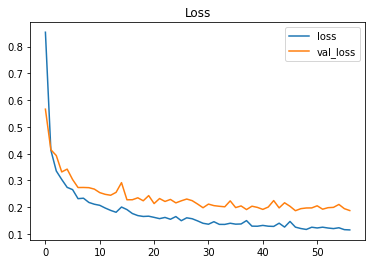

In [36]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

## result

In [37]:
y_pred = model.predict(X_test)

print('mae:',mean_absolute_error(y_test, y_pred), 'mse:',mean_squared_error(y_test, y_pred),  'rmse:',np.sqrt(mean_squared_error(y_test, y_pred)), 'r2:',r2_score(y_test, y_pred))

4/4 [==============================] - 0s 2ms/step
mae: 0.2944963261199648 mse: 0.1555167543813391 rmse: 0.39435612633930145 r2: 0.8344797841491601


In [38]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
MAPE(y_test, y_pred)

81.24185462329714

In [39]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred)) / y_test) * 100 
    
MAPE(y_test, y_pred)

-2.2535211632632586

In [40]:
y_train

array([[ 0.89138665, -0.8252217 , -0.31134341, ..., -1.10180232,
        -1.29908385,  0.71277871],
       [-1.49266128,  1.08807391, -0.31134341, ...,  0.08438461,
         0.35801043, -1.59651747],
       [ 0.55080838, -0.8252217 , -0.5436752 , ..., -0.59343649,
        -0.39521424,  0.71277871],
       ...,
       [-1.37913519,  0.96052087, -0.42750931, ...,  0.08438461,
         0.35801043, -1.3765845 ],
       [-0.01682208, -0.44256257, -1.35683647, ..., -0.76289177,
        -0.24456931, -0.05698668],
       [-1.49266128,  1.08807391, -0.31134341, ...,  0.08438461,
         0.35801043, -1.59651747]])

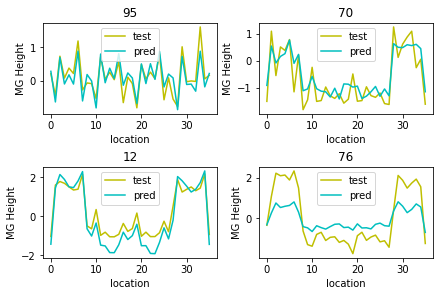

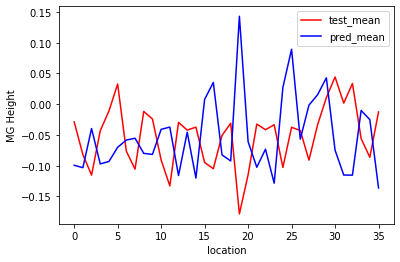

In [41]:
res = random.sample(range(1, y_test.shape[0]), 4)
test_pred_plot(res,y_test, y_pred)
test_pred_mean_plot(y_test, y_pred)

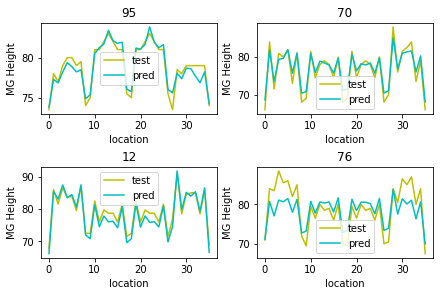

mae: 0.9642529392349465 rmse: 1.2836280065808525 r2: 0.8344797706817448


In [42]:
y_test_rev, y_pred_rev, df_y_test, df_y_pred = scaler_inv(y_test, y_pred)

test_pred_plot(res, df_y_test, df_y_pred)
#test_pred_mean_plot(df_y_test, df_y_pred)

print('mae:',mean_absolute_error(y_test_rev, y_pred_rev), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev)), 'r2:',r2_score(y_test_rev, y_pred_rev))

In [43]:
print('mae(%):',mean_absolute_error(y_test_rev, y_pred_rev)/y_test_rev.mean(), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev))/y_test_rev.mean(), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae(%): 0.012304323220312744 rmse: 0.016379700019527956 r2: 0.8344797706817448


# 1D-CNN

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_test.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_test.shape)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_val.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_val.shape)

X_train의 shape:  (395, 40, 1) , X_test의 shape: (99, 40, 1) , y_train의 shape:  (395, 36) , y_test의 shape: (99, 36)
X_train의 shape:  (316, 40, 1) , X_test의 shape: (79, 40, 1) , y_train의 shape:  (316, 36) , y_test의 shape: (79, 36)


In [45]:
def model_1D_CNN(X_train, y_train,X_val, y_val):
    n_timesteps = 40
    n_features = 1
    n_outputs = 36
    n_kernel_size = 3

    
    model = Sequential()
    model.add(Conv1D(filters=112, kernel_size= 3, input_shape=(n_timesteps,n_features)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(filters=112, kernel_size= 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    '''
    model.add(Conv1D(filters=96, kernel_size= 4,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    '''
    #model.add(MaxPooling2D(pool_size=(3,3), padding='same'))

    model.add(Flatten())
    model.add(Dense(96))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Dense(80))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dense(n_outputs,activation='linear'))
    model.add(Dense(n_outputs,activation=keras.layers.LeakyReLU(alpha=0.55)))



    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train,     batch_size=12, 
                        epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [46]:
def model_1D_CNN(X_train, y_train,X_val, y_val):
    n_timesteps = 40
    n_features = 1
    n_outputs = 36
    n_kernel_size = 3

    model = Sequential()
    model.add(Conv1D(filters=80, kernel_size= 5, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Flatten())
    model.add(Dense(112, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(96, activation='relu'))
    #model.add(Dense(n_outputs,activation='linear'))
    model.add(Dense(n_outputs,activation=keras.layers.LeakyReLU(alpha=0.5))) # , activation=None
    model.summary()


    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train,     batch_size=12, 
                        epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [47]:
model, history = model_1D_CNN(X_train, y_train, X_val, y_val)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 80)            480       
                                                                 
 flatten_1 (Flatten)         (None, 2880)              0         
                                                                 
 dense_5 (Dense)             (None, 112)               322672    
                                                                 
 dropout (Dropout)           (None, 112)               0         
                                                                 
 dense_6 (Dense)             (None, 96)                10848     
                                                                 
 dense_7 (Dense)             (None, 36)                3492      
                                                                 
Total params: 337,492
Trainable params: 337,492
Non-tr

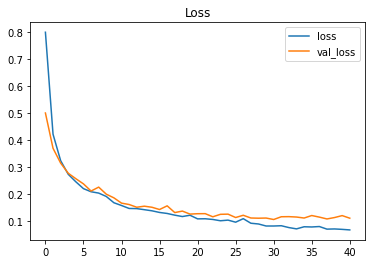

In [48]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

## result

In [49]:
y_pred = model.predict(X_test)

print('mae:',mean_absolute_error(y_test, y_pred), 'mse:',mean_squared_error(y_test, y_pred),'rmse:',np.sqrt(mean_squared_error(y_test, y_pred)), 'r2:',r2_score(y_test, y_pred))

4/4 [==============================] - 0s 26ms/step
mae: 0.20798378111033985 mse: 0.09584719249131829 rmse: 0.30959197743371564 r2: 0.899222909341138


In [50]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
MAPE(y_test, y_pred)

59.35770384727485

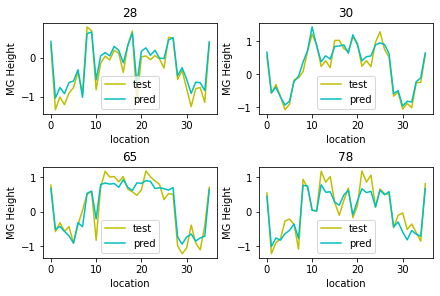

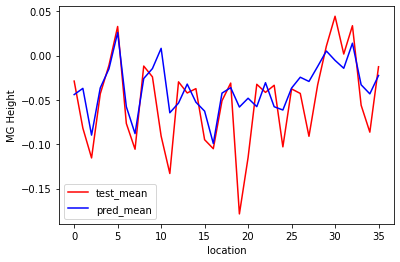

In [51]:
res = random.sample(range(1, y_test.shape[0]), 4)
test_pred_plot(res,y_test, y_pred)
test_pred_mean_plot(y_test, y_pred)

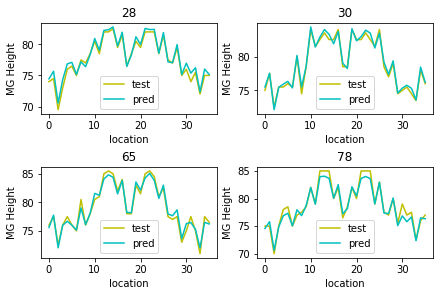

mae: 0.666316214581799 rmse: 0.9624335149860308 r2: 0.8992229059409631


In [52]:
y_test_rev, y_pred_rev, df_y_test, df_y_pred = scaler_inv(y_test, y_pred)

test_pred_plot(res, df_y_test, df_y_pred)
#test_pred_mean_plot(df_y_test, df_y_pred)

print('mae:',mean_absolute_error(y_test_rev, y_pred_rev), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev)), 'r2:',r2_score(y_test_rev, y_pred_rev))

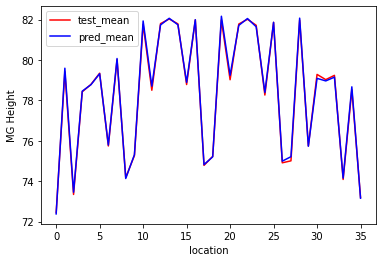

In [53]:
test_pred_mean_plot(df_y_test.T, df_y_pred.T)

In [54]:
print('mae(%):',mean_absolute_error(y_test_rev, y_pred_rev)/y_test_rev.mean(), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev))/y_test_rev.mean(), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae(%): 0.008502509805834342 rmse: 0.01228110650701831 r2: 0.8992229059409631


# 2D-CNN

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_2D, Y, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_test.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_test.shape)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_val.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_val.shape)

X_train의 shape:  (395, 5, 8) , X_test의 shape: (99, 5, 8) , y_train의 shape:  (395, 36) , y_test의 shape: (99, 36)
X_train의 shape:  (316, 5, 8) , X_test의 shape: (79, 5, 8) , y_train의 shape:  (316, 36) , y_test의 shape: (79, 36)


In [56]:
def model_2D_CNN(X_train, y_train, X_val, y_val):
    input_shape = (5,8,1)
    n_outputs = 36
    
    model = Sequential()
    model.add(Conv2D(96, (3,3), input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (4,4) ,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(80, (4,4),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(3,3), padding='same'))

    model.add(Flatten())
    model.add(Dense(48))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(48))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dense(n_outputs,activation='linear'))
    model.add(Dense(n_outputs,activation=keras.layers.LeakyReLU(alpha=0.4)))


    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train,     batch_size=12, 
                        epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [57]:
from tensorflow.keras.layers import Embedding, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

def model_2D_CNN(X_train, y_train, X_val, y_val):
    input_shape = (5,8,1)
    n_outputs = 36
    
    model = Sequential()
    model.add(Conv2D(48, (3,3), activation='relu', input_shape = input_shape))
    model.add(Flatten())
    model.add(Dense(48, activation='relu'))
    model.add(Dropout(0.05))
    model.add(Dense(96, activation='relu'))
    #model.add(Dense(n_outputs,activation='linear'))
    model.add(Dense(n_outputs,activation=keras.layers.LeakyReLU(alpha=0.5)))



    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    early_stopping = EarlyStopping(patience = 10)
    history = model.fit(X_train, y_train,     batch_size=12, 
                        epochs=100, validation_data=(X_val, y_val), callbacks = [early_stopping])
    return model, history

In [58]:
model, history = model_2D_CNN(X_train, y_train, X_val, y_val)

Epoch 1/100
27/27 [==============================] - 1s 10ms/step - loss: 0.9030 - mae: 0.8132 - val_loss: 0.6950 - val_mae: 0.6771
Epoch 2/100
27/27 [==============================] - 0s 4ms/step - loss: 0.5009 - mae: 0.5554 - val_loss: 0.3846 - val_mae: 0.4679
Epoch 3/100
27/27 [==============================] - 0s 4ms/step - loss: 0.3236 - mae: 0.4299 - val_loss: 0.3002 - val_mae: 0.4062
Epoch 4/100
27/27 [==============================] - 0s 4ms/step - loss: 0.2622 - mae: 0.3856 - val_loss: 0.2796 - val_mae: 0.3889
Epoch 5/100
27/27 [==============================] - 0s 5ms/step - loss: 0.2325 - mae: 0.3566 - val_loss: 0.2503 - val_mae: 0.3688
Epoch 6/100
27/27 [==============================] - 0s 4ms/step - loss: 0.2181 - mae: 0.3454 - val_loss: 0.2295 - val_mae: 0.3529
Epoch 7/100
27/27 [==============================] - 0s 4ms/step - loss: 0.1969 - mae: 0.3277 - val_loss: 0.2163 - val_mae: 0.3407
Epoch 8/100
27/27 [==============================] - 0s 4ms/step - loss: 0.1888 - 

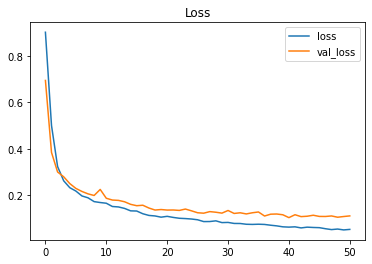

In [59]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

## result

In [60]:
y_pred = model.predict(X_test)

print('mae:',mean_absolute_error(y_test, y_pred), 'mse:',mean_squared_error(y_test, y_pred),'rmse:',np.sqrt(mean_squared_error(y_test, y_pred)), 'r2:',r2_score(y_test, y_pred))

4/4 [==============================] - 0s 19ms/step
mae: 0.20524338343328402 mse: 0.09400339744375158 rmse: 0.3065997349048945 r2: 0.8997038137141671


In [61]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
MAPE(y_test, y_pred)

61.86233948183107

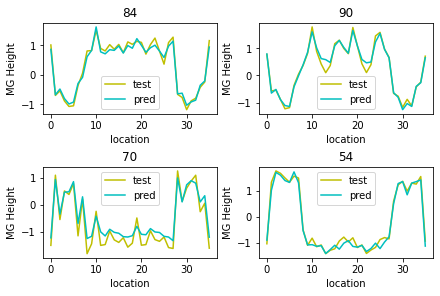

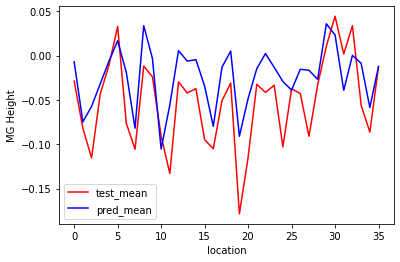

In [62]:
res = random.sample(range(1, y_test.shape[0]), 4)
test_pred_plot(res,y_test, y_pred)
test_pred_mean_plot(y_test, y_pred)

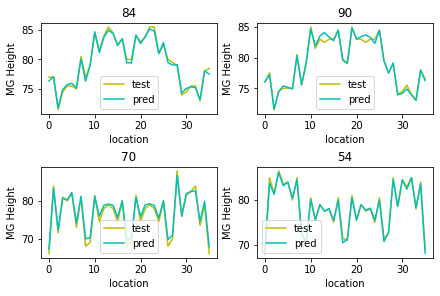

In [63]:
y_test_rev, y_pred_rev, df_y_test, df_y_pred = scaler_inv(y_test, y_pred)

test_pred_plot(res, df_y_test, df_y_pred)
#test_pred_mean_plot(df_y_test, df_y_pred)

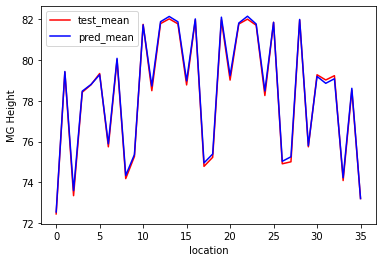

In [64]:
test_pred_mean_plot(df_y_test.T, df_y_pred.T)

In [65]:
print('mae:',mean_absolute_error(y_test_rev, y_pred_rev), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev)), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae: 0.6612336069914093 rmse: 0.9804122837733292 r2: 0.8997038161783488


In [66]:
print('mae(%):',mean_absolute_error(y_test_rev, y_pred_rev)/y_test_rev.mean(), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev))/y_test_rev.mean(), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae(%): 0.008437653330889305 rmse: 0.012510524093691893 r2: 0.8997038161783488


## 시각화

In [67]:
def Y_array_2D(X):
    N = X.shape[1]
    X_re = np.zeros((N, 4, 9))
    for k in range(N):
        for i in range(4):
            X_re[k, i,: ]  = X.T.iloc[k,i*4:i*4+9]
    return X_re

# Y_array()
test_ar = Y_array_2D(df_y_test)
pred_ar = Y_array_2D(df_y_pred)

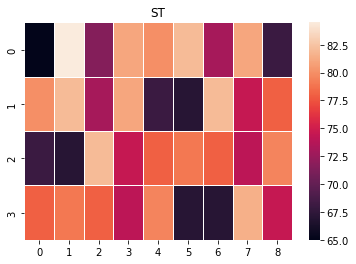

In [68]:
sns.heatmap(test_ar[0], linewidth=0.5)
plt.title('ST')
plt.show()

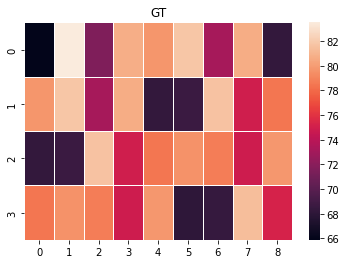

In [69]:
sns.heatmap(pred_ar[0], linewidth=0.5)
plt.title('GT')
plt.show()

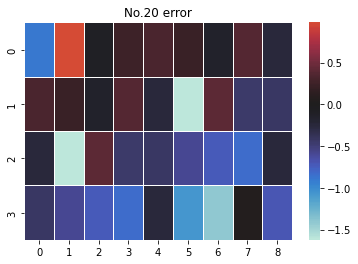

In [70]:
i = 0
sns.heatmap(test_ar[i] - pred_ar[i], linewidth=0.5, center=0)
plt.title('No.20 error')
plt.show()

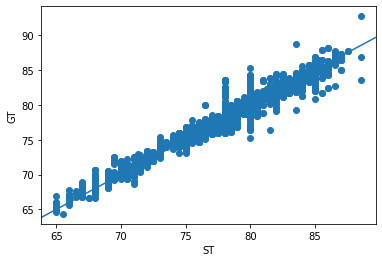

In [71]:
plt.scatter(test_ar,pred_ar)
plt.axline((65, 65), slope=1)
plt.ylabel('GT')
plt.xlabel('ST')
plt.show()

In [72]:
test_ar[0][0]

array([65. , 84.5, 71.5, 81. , 80. , 82. , 73. , 81. , 68. ])

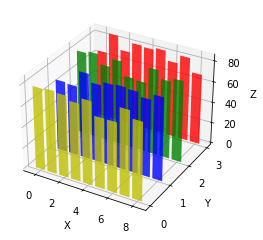

In [73]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = ['r', 'g', 'b', 'y']
yticks = [3, 2, 1, 0]

for c, k, j in zip(colors, yticks, range(4)):
    # Generate the random data for the y=k 'layer'.
    xs = np.arange(9)
    ys = test_ar[0][j]

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    #cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)

plt.show()

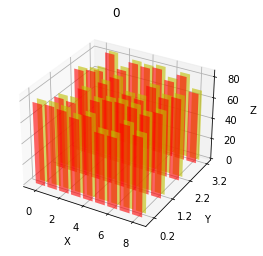

In [74]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = ['r', 'r', 'r', 'r']
yticks = [3, 2, 1, 0]
for c, k, j in zip(colors, yticks, range(4)):
    # Generate the random data for the y=k 'layer'.
    xs = np.arange(9)
    ys = test_ar[0][j]

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    #cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.6)

colors = ['y', 'y', 'y', 'y']
yticks = [3.2, 2.2, 1.2, 0.2]
for c, k, j in zip(colors, yticks, range(4)):
    # Generate the random data for the y=k 'layer'.
    xs = np.arange(9)
    ys = pred_ar[0][j]

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    #cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.6)
 
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)
plt.title('0')
plt.show()

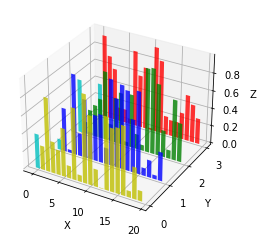

In [75]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = ['r', 'g', 'b', 'y']
yticks = [3, 2, 1, 0]
for c, k in zip(colors, yticks):
    # Generate the random data for the y=k 'layer'.
    xs = np.arange(20)
    ys = np.random.rand(20)

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    cs = [c] * len(xs)
    cs[0] = 'c'

    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    ax.bar(xs, ys, zs=k, zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)

plt.show()

# ResNet

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_2D, Y, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_test.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_test.shape)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train의 shape: ', X_train.shape ,', X_test의 shape:',X_val.shape,
     ', y_train의 shape: ', y_train.shape ,', y_test의 shape:',y_val.shape)

X_train의 shape:  (395, 5, 8) , X_test의 shape: (99, 5, 8) , y_train의 shape:  (395, 36) , y_test의 shape: (99, 36)
X_train의 shape:  (316, 5, 8) , X_test의 shape: (79, 5, 8) , y_train의 shape:  (316, 36) , y_test의 shape: (79, 36)


In [77]:
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X_shortcut = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [78]:
def ResNet50CL(input_shape = (5,8,1), classes = 10):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 64, (3,3)) #conv
    X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 128, (3,3)) #64->128, use conv block
    X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 256, (3,3)) #128->256, use conv block
    X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 512, (3,3)) #256->512, use conv block
    X = identity_block(X, 512, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(36, activation = 'softmax')(X) # ouput layer (10 class)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "ResNet50CL")
    
    return model

In [79]:
def ResNet50C(input_shape = (5,8,1), classes = 10):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 64, (3,3)) #conv
    X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 128, (3,3)) #64->128, use conv block
    X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
   
    X = convolutional_block(X, 256, (3,3)) #128->256, use conv block
    X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    '''
    X = convolutional_block(X, 512, (3,3)) #256->512, use conv block
    X = identity_block(X, 512, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    '''
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(36, activation = keras.layers.LeakyReLU(alpha=0.4))(X) # ouput layer (10 class)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "ResNet50C")
    
    return model

In [80]:
model = ResNet50C()
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "ResNet50C"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 8, 1)]    0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 8, 64)     640         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 5, 8, 64)    256         ['conv2d_1[0][0]']               
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 5, 8, 64)     0           ['batch_normalization[0][

In [81]:
EPOCH = 50
BATCH_SIZE = 4

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                              patience=10, 
                             )

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
)


In [82]:
history = model.fit(X_train, y_train,
                 validation_data=(X_val, y_val), 
                 epochs=EPOCH, 
                 batch_size=BATCH_SIZE, 
                 callbacks=[reduceLR, earlystopping],)

Epoch 1/50
79/79 [==============================] - 4s 23ms/step - loss: 0.9534 - mae: 0.7458 - val_loss: 1.0415 - val_mae: 0.8744 - lr: 0.0010
Epoch 2/50
79/79 [==============================] - 1s 19ms/step - loss: 0.3641 - mae: 0.4482 - val_loss: 0.9483 - val_mae: 0.8334 - lr: 0.0010
Epoch 3/50
79/79 [==============================] - 1s 18ms/step - loss: 0.3204 - mae: 0.4227 - val_loss: 0.6505 - val_mae: 0.6411 - lr: 0.0010
Epoch 4/50
79/79 [==============================] - 1s 18ms/step - loss: 0.2452 - mae: 0.3663 - val_loss: 0.5855 - val_mae: 0.5901 - lr: 0.0010
Epoch 5/50
79/79 [==============================] - 1s 19ms/step - loss: 0.2159 - mae: 0.3411 - val_loss: 0.3562 - val_mae: 0.4431 - lr: 0.0010
Epoch 6/50
79/79 [==============================] - 1s 18ms/step - loss: 0.2081 - mae: 0.3254 - val_loss: 0.2265 - val_mae: 0.3542 - lr: 0.0010
Epoch 7/50
79/79 [==============================] - 2s 20ms/step - loss: 0.1814 - mae: 0.3116 - val_loss: 0.2290 - val_mae: 0.3310 - lr:

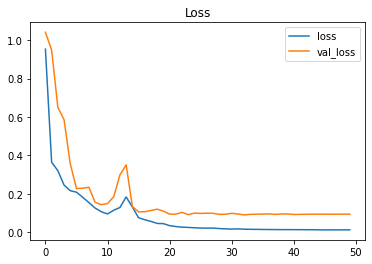

In [83]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.show()

In [84]:
y_pred = model.predict(X_test)

print('mae:',mean_absolute_error(y_test, y_pred), 'mse:',mean_squared_error(y_test, y_pred),'rmse:',np.sqrt(mean_squared_error(y_test, y_pred)), 'r2:',r2_score(y_test, y_pred))

4/4 [==============================] - 5s 6ms/step
mae: 0.1999484369927766 mse: 0.1089825956092459 rmse: 0.3301251211423419 r2: 0.8848203683734183


In [85]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
MAPE(y_test, y_pred)

53.87139040197763

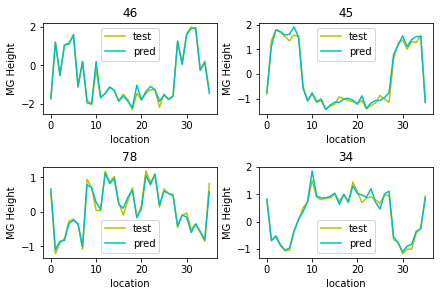

In [86]:
res = random.sample(range(1, y_test.shape[0]), 4)
test_pred_plot(res,y_test, y_pred)

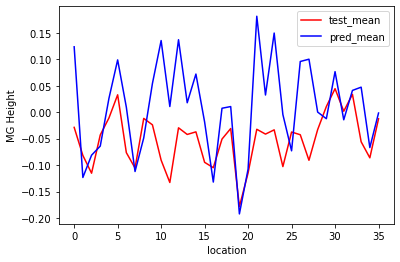

In [87]:
test_pred_mean_plot(y_test, y_pred)

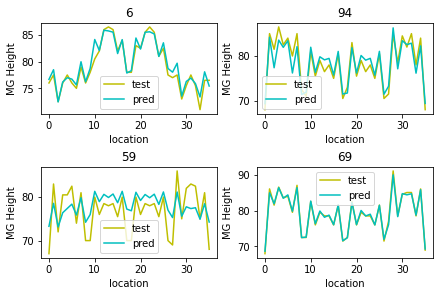

In [88]:
res = random.sample(range(1, y_test.shape[0]), 4)
y_test_rev, y_pred_rev, df_y_test, df_y_pred = scaler_inv(y_test, y_pred)

test_pred_plot(res, df_y_test, df_y_pred)
#test_pred_mean_plot(df_y_test, df_y_pred)

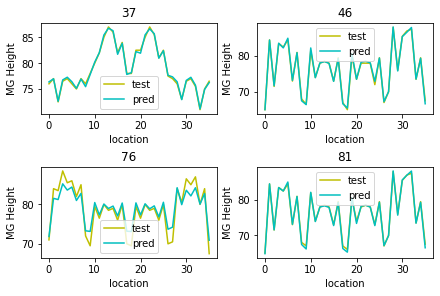

In [89]:
# 예측이 잘 되지 않은 test data(random state=36)
res =  [37,46,76,81]
test_pred_plot(res, df_y_test, df_y_pred)

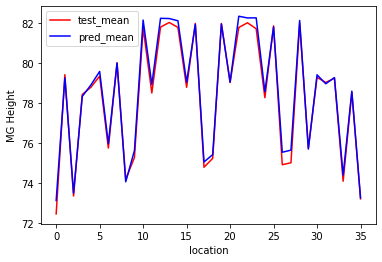

In [90]:
test_pred_mean_plot(df_y_test.T, df_y_pred.T)

In [91]:
print('mae:',mean_absolute_error(y_test_rev, y_pred_rev), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev)), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae: 0.64868869546019 rmse: 1.080855802402603 r2: 0.8848203649477884


In [92]:
print('mae(%):',mean_absolute_error(y_test_rev, y_pred_rev)/y_test_rev.mean(), 'rmse:',np.sqrt(mean_squared_error(y_test_rev, y_pred_rev))/y_test_rev.mean(), 'r2:',r2_score(y_test_rev, y_pred_rev))

mae(%): 0.008277574330899096 rmse: 0.013792230862022473 r2: 0.8848203649477884
